In [7]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import h5py

In [8]:
filename='../solutions/sample_2e7_design_precessing_higherordermodes_3detectors.h5'
with h5py.File(filename, 'r') as f:
    mtot = f['mtot'][:]
    q = f['q'][:]
    z = f['z'][:]
    det = f['det'][:]

In [9]:
#downsampling
N = 10000
idx = np.random.choice(len(mtot), size=N, replace=False)

X = np.column_stack([mtot[idx], q[idx], z[idx]])
y = det[idx]


We use DEcision Tree as our classifier

let's use cross validation in order to find the optimal leaf

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

y_pred = grid.predict(X_test)


Best params: {'max_depth': 5}


In [20]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


completeness = recall_score(y_test, y_pred, pos_label=1)
print(f"Completeness (Recall on det=1): {completeness:.3f}")

from sklearn.metrics import precision_score
contamination = 1 - precision_score(y_test, y_pred, pos_label=1)
print(f"Contamination: {contamination:.3f}")

print(f"accuracy: {accuracy_score(y_test, y_pred):.3f}")

Completeness (Recall on det=1): 0.671
Contamination: 0.130
accuracy: 0.936


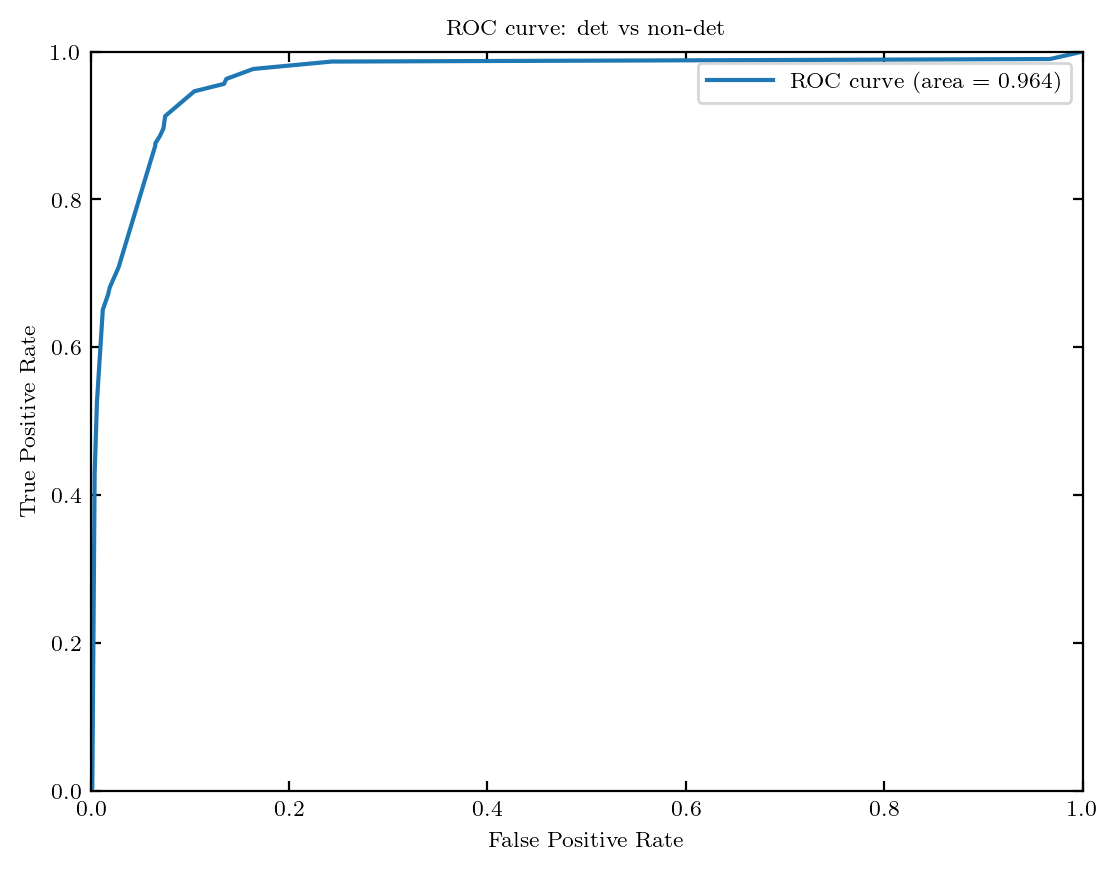

In [17]:
from sklearn.metrics import roc_curve, auc

y_scores = grid.best_estimator_.predict_proba(X_test)[:,1]  # proba di det=1
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: det vs non-det")
plt.legend()
plt.show()

let's use random forest to improve accuracy


In [34]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20]
    }
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(
)


grid = GridSearchCV(
    rf_clf, 
    param_grid, 
    cv=5, 

)

grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 200, 300]})

In [35]:
print("✅ Miglior numero di estimatori trovato:")
print(grid.best_params_)

✅ Miglior numero di estimatori trovato:
{'max_depth': 15, 'n_estimators': 300}


In [36]:

y_pred = grid.predict(X_test)

In [37]:
print(f"accuracy: {accuracy_score(y_test, y_pred):.3f}")

accuracy: 0.939
